In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, plot_roc_curve, auc, precision_recall_curve, classification_report, plot_confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
# READ CSV FILE

aug_train = pd.read_csv('aug_train.csv')
aug_test = pd.read_csv('aug_test.csv')

In [3]:
# First Few Rows

aug_train.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
# Info

aug_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [5]:
# Null Value

aug_train.isnull().sum()/len(aug_train)*100

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

## Feature Enginering

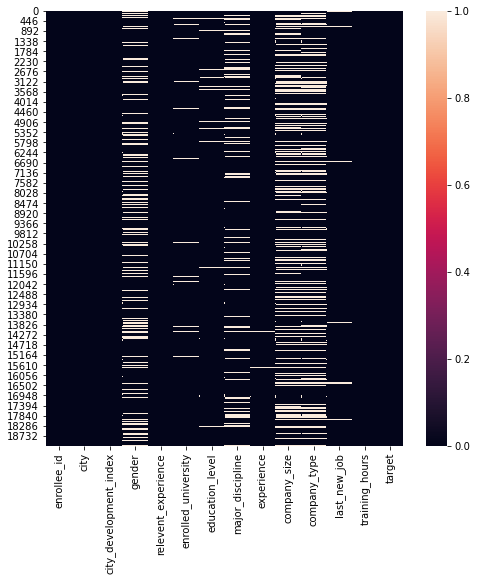

In [6]:
plt.figure(figsize=(8,8))
sns.heatmap(aug_train.isna())
plt.show()

# **Data Visualization**

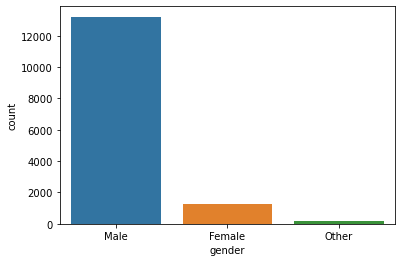

In [7]:
sns.countplot (aug_train['gender'])
plt.show()

Laki-laki lebih banyak mencari pekerjaan baru dibanding perempuan

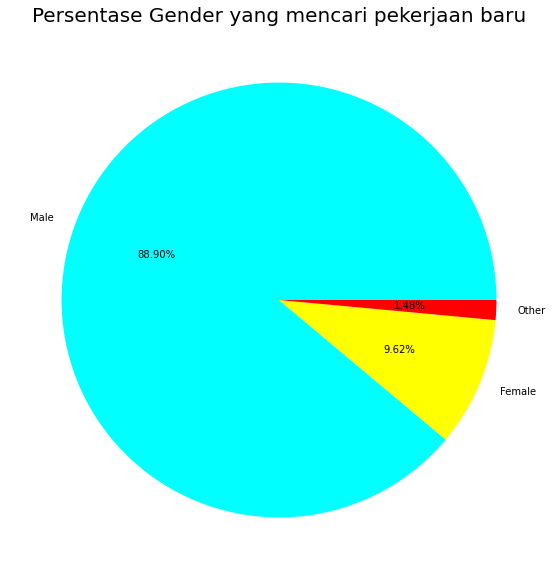

In [8]:
plt.figure(figsize=(10,10))
gender = aug_train[aug_train['target'] == 1] ['gender']
temp = gender.value_counts()
labels = temp.keys()
plt.pie(x = temp, labels = labels, colors = ['cyan', 'yellow', 'red'], autopct = '%.2f%%')
plt.title ('Persentase Gender yang mencari pekerjaan baru', fontsize = 20)
plt.show()

Laki-laki yang mencari pekerjaan baru sebanyak **88.90%**, wanita **9.62%**, dan Others **1.48**

In [9]:
L_new = aug_train[(aug_train['gender'] == 'Male') & aug_train['target'] == 1]
W_new = aug_train[(aug_train['gender'] == 'Female') & aug_train['target'] == 1]

# Print
print('{}% Banyaknya laki-laki yang mencari pekerjaan baru'. format(len(L_new)/len(aug_train['gender']=='Male')*100))
print('{}% Banyaknya Perempuan yang mencari pekerjaan baru'. format(len(W_new)/len(aug_train['gender']=='Female')*100))

15.721891637958032% Banyaknya laki-laki yang mencari pekerjaan baru
1.7016390019835057% Banyaknya Perempuan yang mencari pekerjaan baru


## Dari perusahaan seperti apa orang-orang mencari pekerjaan baru

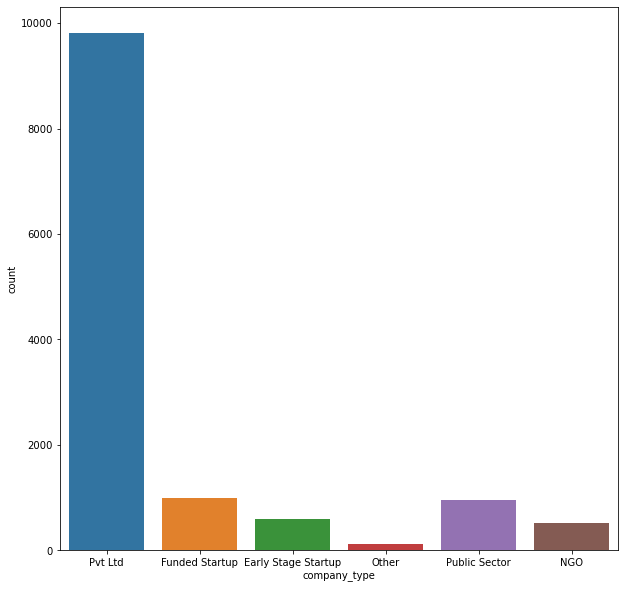

In [10]:
plt.figure(figsize=(10,10))
sns.countplot(aug_train['company_type'])
plt.show()

dari data yang ditampilkan di atas, kita dapat lihat, kebanyakan orang bekerja di *Private Company*

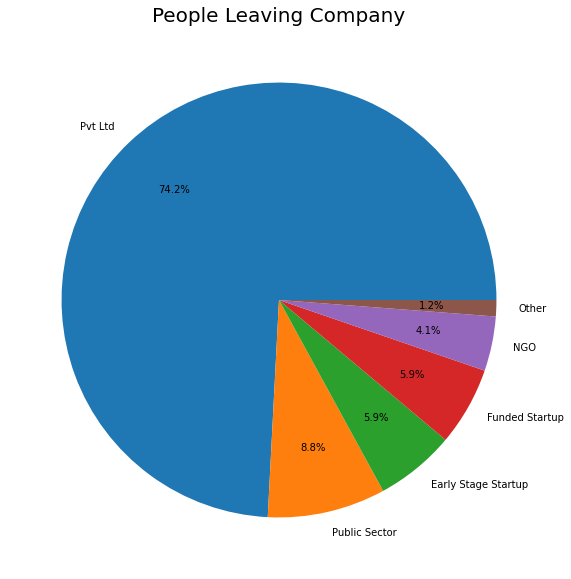

In [11]:
plt.figure(figsize=(10,10))
C_type = aug_train[aug_train['target'] == 1 ]['company_type']
temp = C_type.value_counts()
labels = temp.keys()
plt.pie(x = temp, labels = labels, autopct = '%.1f%%', pctdistance = 0.7)
plt.title('People Leaving Company', fontsize = 20)
plt.show()

In [12]:
for i in aug_train['company_type'].unique():
    C_new = aug_train[(aug_train['company_type'] == i) & aug_train['target'] == 1]
    print ('{} % of {} Yang mencari pekerjaan baru'.format(len(C_new)/len(aug_train['company_type']==i)*100, i))

0.0 % of nan Yang mencari pekerjaan baru
9.2650589831924 % of Pvt Ltd Yang mencari pekerjaan baru
0.7307652155757386 % of Funded Startup Yang mencari pekerjaan baru
0.741204718655392 % of Early Stage Startup Yang mencari pekerjaan baru
0.15137279465497444 % of Other Yang mencari pekerjaan baru
1.096147823363608 % of Public Sector Yang mencari pekerjaan baru
0.5063158993631903 % of NGO Yang mencari pekerjaan baru


*dari data diatas dapat dilihat banyaknya orang yang mencari pekerjaan baru berasal dari *private company*

## apakah orang yang memiliki pengalaman mencari pekerjaan baru?

<AxesSubplot:xlabel='relevent_experience', ylabel='count'>

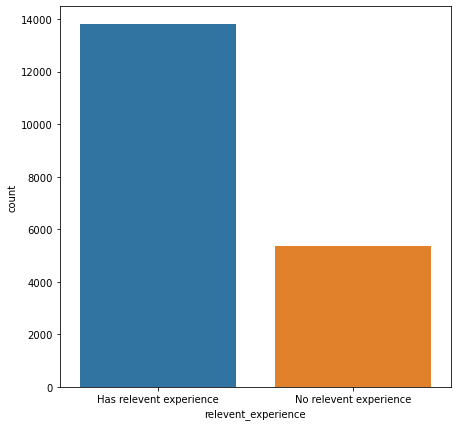

In [13]:
plt.figure(figsize=(7,7))
sns.countplot(aug_train['relevent_experience'])

*Dari data yang ditampilkan di atas orang yang memiliki pengalaman lebih banyak mencari pekerjaan baru dibanding dengan orang yang belum memiliki pengalaman*

<function matplotlib.pyplot.show(close=None, block=None)>

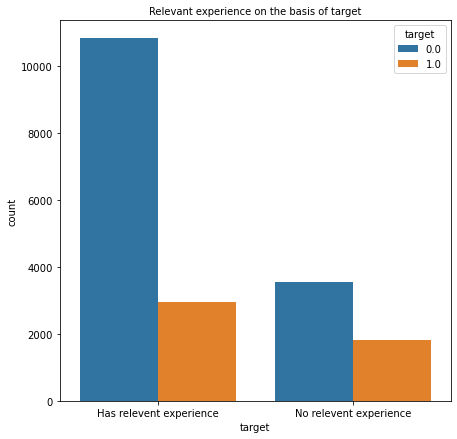

In [14]:
plt.figure(figsize=(7,7))
sns.countplot(aug_train['relevent_experience'], hue = aug_train['target'])
plt.xlabel ('target')
plt.ylabel ('count')
plt.title ('Relevant experience on the basis of target', fontsize = 10)
plt.show

*Keterangan : 0.0 -- Tidak mencari Pekerjaan Baru , 1.0 -- mencari pekerjaan baru*

In [15]:
yes_newjob = aug_train[(aug_train['relevent_experience']=='Has relevent experience') & aug_train['target']==1]
no_newjob = aug_train[(aug_train['relevent_experience']=='No relevent experience') & aug_train['target']==1]

# Print
print ('{}% Orang yang memiliki pengalaman dan mencari pekerjaan baru'.format (len(yes_newjob)/len(aug_train['relevent_experience']=='Memiliki Pengalaman')*100))
print ('{}% Orang yang tidak memiliki pengalaman dan mencari pekerjaan baru'.format(len(no_newjob)/len(aug_train['relevent_experience']=='Tidak memiliki pengalaman')*100))

15.45568430942687% Orang yang memiliki pengalaman dan mencari pekerjaan baru
9.479068796325295% Orang yang tidak memiliki pengalaman dan mencari pekerjaan baru


## Level Edukasi Setiap Orang

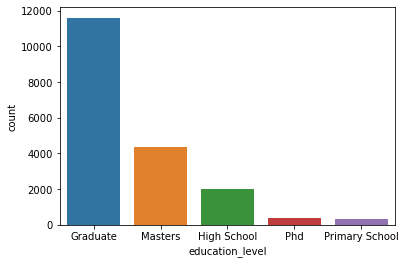

In [16]:
sns.countplot(aug_train['education_level'])
plt.show()

In [17]:
ppl = aug_train[(aug_train['education_level'] == 'Primary School')& (aug_train['education_level'] == 'High School')& (aug_train['enrolled_university'] == 'no_enrollment')]

print ('Orang yang mencari kerja tanpa memiliki kelulusan universitas / gelar', len(ppl))

Orang yang mencari kerja tanpa memiliki kelulusan universitas / gelar 0


*jadi tidak ada orang yang masuk kedalam bidang ini tanpa memiliki gelar*

## Jarak antara pekerjaan terakhir dan pekerjaan sekarang

<AxesSubplot:xlabel='last_new_job', ylabel='count'>

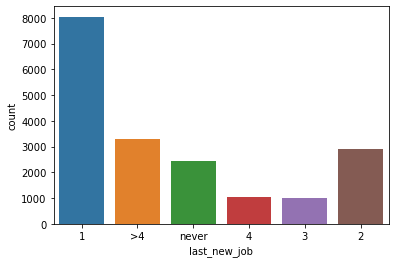

In [18]:
sns.countplot(aug_train['last_new_job'])

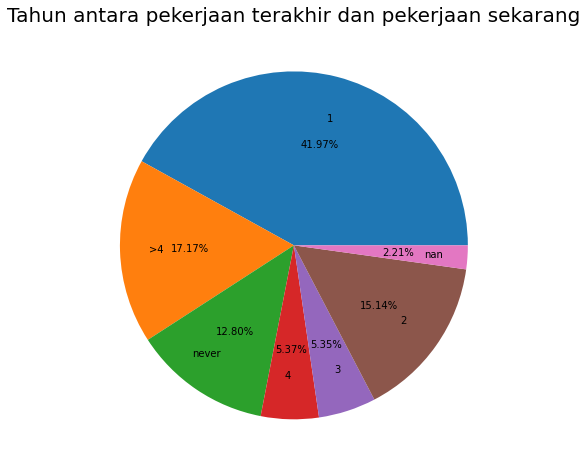

In [19]:
plt.figure(figsize=(8,8))
count = Counter(aug_train['last_new_job'])
plt.pie(count.values(), labels = count.keys(), labeldistance = 0.75, autopct = lambda p:f'{p:.2f}%')
plt.title ('Tahun antara pekerjaan terakhir dan pekerjaan sekarang', fontsize = 20)
plt.show()

## Preprocesing

In [20]:
# Creating a function that converts all values of , ['gender'], ['relevent_experience'] , ['enrolled_university'],
# , ['education_level'], ['major_discipline'], ['experience'], ['company_type'],  ['company_size']
# , ['last_new_job'], ['city'] into numbers

def gender_to_numeric(x):
    if x=='Female': return 2
    if x=='Male':   return 1
    if x=='Other':   return 0
    
def rel_experience(x):
    if x=='Has relevent experience': return 1
    if x=='No relevent experience':   return 0
    
def enrollment(x):
    if x=='no_enrollment'   : return 0
    if x=='Full time course':   return 1 
    if x=='Part time course':   return 2 
    
def edu_level(x):
    if x=='Graduate'       :   return 0
    if x=='Masters'        :   return 1 
    if x=='High School'    :   return 2 
    if x=='Phd'            :   return 3 
    if x=='Primary School' :   return 4 
    
def major(x):
    if x=='STEM'                   :   return 0
    if x=='Business Degree'        :   return 1 
    if x=='Arts'                   :   return 2 
    if x=='Humanities'             :   return 3 
    if x=='No Major'               :   return 4 
    if x=='Other'                  :   return 5 
    
def experience(x):
    if x=='<1'      :   return 0
    if x=='1'       :   return 1 
    if x=='2'       :   return 2 
    if x=='3'       :   return 3 
    if x=='4'       :   return 4 
    if x=='5'       :   return 5
    if x=='6'       :   return 6
    if x=='7'       :   return 7
    if x=='8'       :   return 8 
    if x=='9'       :   return 9 
    if x=='10'      :   return 10 
    if x=='11'      :   return 11
    if x=='12'      :   return 12
    if x=='13'      :   return 13 
    if x=='14'      :   return 14 
    if x=='15'      :   return 15 
    if x=='16'      :   return 16
    if x=='17'      :   return 17
    if x=='18'      :   return 18
    if x=='19'      :   return 19 
    if x=='20'      :   return 20 
    if x=='>20'     :   return 21 
    
def company_t(x):
    if x=='Pvt Ltd'               :   return 0
    if x=='Funded Startup'        :   return 1 
    if x=='Early Stage Startup'   :   return 2 
    if x=='Other'                 :   return 3 
    if x=='Public Sector'         :   return 4 
    if x=='NGO'                   :   return 5 
    
def company_s(x):
    if x=='<10'          :   return 0
    if x=='10/49'        :   return 1 
    if x=='100-500'      :   return 2 
    if x=='1000-4999'    :   return 3 
    if x=='10000+'       :   return 4 
    if x=='50-99'        :   return 5 
    if x=='500-999'      :   return 6 
    if x=='5000-9999'    :   return 7
    
def last_job(x):
    if x=='never'        :   return 0
    if x=='1'            :   return 1 
    if x=='2'            :   return 2 
    if x=='3'            :   return 3 
    if x=='4'            :   return 4 
    if x=='>4'           :   return 5 
    
def city(x):
    if x=='city_103'         : return  103
    if x=='city_40'          : return  40
    if x=='city_21'          : return  21
    if x=='city_115'         : return  115
    if x=='city_162'         : return  162
    if x=='city_176'         : return  176
    if x=='city_160'         : return  160
    if x=='city_46'          : return  46
    if x=='city_61'          : return  61
    if x=='city_114'         : return  114
    if x=='city_13'          : return  13
    if x=='city_159'         : return  159
    if x=='city_102'         : return  102
    if x=='city_67'          : return  67
    if x=='city_100'         : return  100
    if x=='city_16'          : return  16
    if x=='city_71'          : return  71
    if x=='city_104'         : return  104
    if x=='city_64'          : return  64
    if x=='city_101'         : return  101
    if x=='city_83'          : return  83
    if x=='city_105'         : return  105
    if x=='city_73'          : return  73
    if x=='city_75'          : return  75
    if x=='city_41'          : return  41
    if x=='city_11'          : return  11
    if x=='city_93'          : return  93
    if x=='city_90'          : return  90
    if x=='city_36'          : return  36
    if x=='city_20'          : return  20
    if x=='city_57'          : return  57
    if x=='city_152'         : return  152
    if x=='city_19'          : return  19
    if x=='city_65'          : return  65
    if x=='city_74'          : return  74
    if x=='city_173'         : return  173
    if x=='city_136'         : return  136
    if x=='city_98'          : return  98
    if x=='city_97'          : return  97
    if x=='city_50'          : return  50
    if x=='city_138'         : return  138
    if x=='city_82'          : return  82
    if x=='city_157'         : return  157
    if x=='city_89'          : return  89
    if x=='city_150'         : return  150
    if x=='city_70'          : return  70
    if x=='city_175'         : return  175
    if x=='city_94'          : return  94
    if x=='city_28'          : return  28
    if x=='city_59'          : return  59
    if x=='city_165'         : return  165
    if x=='city_145'         : return  145
    if x=='city_142'         : return  142
    if x=='city_26'          : return  26
    if x=='city_12'          : return  12
    if x=='city_37'          : return  37
    if x=='city_43'          : return  43
    if x=='city_116'         : return  116
    if x=='city_23'          : return  23
    if x=='city_99'          : return  99
    if x=='city_149'         : return  149
    if x=='city_10'          : return  10
    if x=='city_45'          : return  45
    if x=='city_80'          : return  80
    if x=='city_128'         : return  128
    if x=='city_158'         : return  158
    if x=='city_123'         : return  123
    if x=='city_7'           : return  7
    if x=='city_72'          : return  72
    if x=='city_106'         : return  106
    if x=='city_143'         : return  143
    if x=='city_78'          : return  78
    if x=='city_109'         : return  109
    if x=='city_24'          : return  24
    if x=='city_134'         : return  134
    if x=='city_48'          : return  48
    if x=='city_144'         : return  144
    if x=='city_91'          : return  97
    if x=='city_146'         : return  146
    if x=='city_133'         : return  133
    if x=='city_126'         : return  126
    if x=='city_118'         : return  118
    if x=='city_9'           : return  9
    if x=='city_167'         : return  167
    if x=='city_27'          : return  27
    if x=='city_84'          : return  84
    if x=='city_54'          : return  54
    if x=='city_39'          : return  39
    if x=='city_79'          : return  79
    if x=='city_76'          : return  76
    if x=='city_77'          : return  77
    if x=='city_81'          : return  87
    if x=='city_131'         : return  131
    if x=='city_44'          : return  44
    if x=='city_117'         : return  117
    if x=='city_155'         : return  155
    if x=='city_33'          : return  33
    if x=='city_141'         : return  141
    if x=='city_127'         : return  127
    if x=='city_62'          : return  62
    if x=='city_53'          : return  53
    if x=='city_25'          : return  25
    if x=='city_2'           : return  2
    if x=='city_69'          : return  69
    if x=='city_120'         : return  120
    if x=='city_111'         : return  111
    if x=='city_30'          : return  30
    if x=='city_1'           : return  1
    if x=='city_140'         : return  140
    if x=='city_179'         : return  179
    if x=='city_55'          : return  55
    if x=='city_14'          : return  14
    if x=='city_42'          : return  42
    if x=='city_107'         : return  107
    if x=='city_18'          : return  18
    if x=='city_139'         : return  139
    if x=='city_180'         : return  180
    if x=='city_166'         : return  166
    if x=='city_121'         : return  121
    if x=='city_129'         : return  129
    if x=='city_8'           : return  8
    if x=='city_31'          : return  31
    if x=='city_171'         : return  171

In [21]:
# AUG_TRAIN
aug_train['gender'] = aug_train['gender'].apply(gender_to_numeric)
aug_train['relevent_experience'] = aug_train['relevent_experience'].apply(rel_experience)
aug_train['enrolled_university'] = aug_train['enrolled_university'].apply(enrollment)
aug_train['education_level'] = aug_train['education_level'].apply(edu_level)
aug_train['major_discipline'] = aug_train['major_discipline'].apply(major)
aug_train['experience'] = aug_train['experience'].apply(experience)
aug_train['company_type'] = aug_train['company_type'].apply(company_t)
aug_train['company_size'] = aug_train['company_size'].apply(company_s)
aug_train['last_new_job'] = aug_train['last_new_job'].apply(last_job)
aug_train['city'] = aug_train['city'].apply(city)

# AUG_TEST
aug_test['gender'] = aug_test['gender'].apply(gender_to_numeric)
aug_test['relevent_experience'] = aug_test['relevent_experience'].apply(rel_experience)
aug_test['enrolled_university'] = aug_test['enrolled_university'].apply(enrollment)
aug_test['education_level'] = aug_test['education_level'].apply(edu_level)
aug_test['major_discipline'] = aug_test['major_discipline'].apply(major)
aug_test['experience'] = aug_test['experience'].apply(experience)
aug_test['company_type'] = aug_test['company_type'].apply(company_t)
aug_test['company_size'] = aug_test['company_size'].apply(company_s)
aug_test['last_new_job'] = aug_test['last_new_job'].apply(last_job)
aug_test['city'] = aug_test['city'].apply(city)

### Check Missing Value

In [22]:
# cek missing value aug_train
print ("Apakah ada Missing Value :", aug_train.isnull().values.any())

#cek missing value aug_test
print ("Apakah ada Missing Value :", aug_test.isnull().values.any())

Apakah ada Missing Value : True
Apakah ada Missing Value : True


In [23]:
aug_train.isnull().sum()/len(aug_train)*100

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

*Kolom yang memiliki nilai 2% atau lebih kecil, akan di drop*

### Replace Missing Value

In [24]:
# Menghilangkan missing value pada data set aug_train
aug_train['gender'] = aug_train['gender'].fillna((aug_train['gender'].mean()))
aug_train['enrolled_university'] = aug_train['enrolled_university'].fillna((aug_train['enrolled_university'].mean()))
aug_train['major_discipline'] = aug_train['major_discipline'].fillna((aug_train['major_discipline'].mean()))
aug_train['company_size'] = aug_train['company_size'].fillna((aug_train['company_size'].mean()))
aug_train['company_type'] = aug_train['company_type'].fillna((aug_train['company_type'].mean()))
aug_train.dropna(subset=['education_level','experience','last_new_job'], axis =0, inplace=True)

# menghilangkan missing value pada set aug_test
aug_test['gender'] = aug_test['gender'].fillna((aug_test['gender'].mean()))
aug_test['enrolled_university'] = aug_test['enrolled_university'].fillna((aug_test['enrolled_university'].mean()))
aug_test['major_discipline'] = aug_test['major_discipline'].fillna((aug_test['major_discipline'].mean()))
aug_test['company_size'] = aug_test['company_size'].fillna((aug_test['company_size'].mean()))
aug_test['company_type'] = aug_test['company_type'].fillna((aug_test['company_type'].mean()))
aug_test.dropna(subset=['education_level','experience','last_new_job'], axis =0, inplace=True)

In [25]:
aug_train.isnull().sum()/len(aug_train)*100

enrollee_id               0.0
city                      0.0
city_development_index    0.0
gender                    0.0
relevent_experience       0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
training_hours            0.0
target                    0.0
dtype: float64

In [26]:
aug_test.isnull().sum()/len(aug_test)*100

enrollee_id               0.0
city                      0.0
city_development_index    0.0
gender                    0.0
relevent_experience       0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
training_hours            0.0
dtype: float64

In [27]:
aug_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,1.000000,1,0.000000,0.0,0.0,21.0,3.27466,0.690966,1.0,36,1.0
1,29725,40,0.776,1.000000,0,0.000000,0.0,0.0,15.0,5.00000,0.000000,5.0,47,0.0
2,11561,21,0.624,1.071468,0,1.000000,0.0,0.0,5.0,3.27466,0.690966,0.0,83,0.0
3,33241,115,0.789,1.071468,0,0.327775,0.0,1.0,0.0,3.27466,0.000000,0.0,52,1.0
4,666,162,0.767,1.000000,1,0.000000,1.0,0.0,21.0,5.00000,1.000000,4.0,8,0.0


## Feature Selection For The Model

In [28]:
# memilih 8 Fitur terbaik dari dataset
fiture =SelectKBest(score_func=f_classif,k=8)
fit=fiture.fit(aug_train.drop(columns=['target']),aug_train['target'])

In [29]:
features=fit.transform(aug_train.drop(columns=['target']))
print(features[:5,:])

[[8.9490000e+03 1.0300000e+02 9.2000000e-01 1.0000000e+00 0.0000000e+00
  0.0000000e+00 2.1000000e+01 1.0000000e+00]
 [2.9725000e+04 4.0000000e+01 7.7600000e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.5000000e+01 5.0000000e+00]
 [1.1561000e+04 2.1000000e+01 6.2400000e-01 0.0000000e+00 1.0000000e+00
  0.0000000e+00 5.0000000e+00 0.0000000e+00]
 [3.3241000e+04 1.1500000e+02 7.8900000e-01 0.0000000e+00 3.2777541e-01
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [6.6600000e+02 1.6200000e+02 7.6700000e-01 1.0000000e+00 0.0000000e+00
  1.0000000e+00 2.1000000e+01 4.0000000e+00]]


In [30]:
data2=aug_train[["city" , "city_development_index","gender",
                 "relevent_experience","enrolled_university","education_level",
                 "company_size","company_type",'target']]

In [31]:
data2.head(5)

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,company_size,company_type,target
0,103,0.920,1.000000,1,0.000000,0.0,3.27466,0.690966,1.0
1,40,0.776,1.000000,0,0.000000,0.0,5.00000,0.000000,0.0
2,21,0.624,1.071468,0,1.000000,0.0,3.27466,0.690966,0.0
3,115,0.789,1.071468,0,0.327775,0.0,3.27466,0.000000,1.0
4,162,0.767,1.000000,1,0.000000,1.0,5.00000,1.000000,0.0


### Proces data

In [32]:
X = data2.drop(columns=['target']).values
y = data2['target'].values

<AxesSubplot:xlabel='target', ylabel='count'>

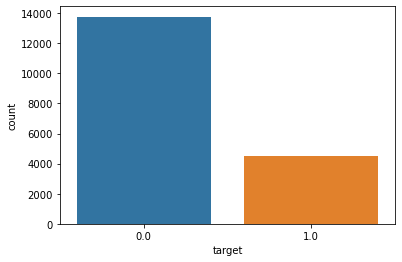

In [33]:
sns.countplot(data2['target'])

In [34]:
data2.target.value_counts()

0.0    13765
1.0     4515
Name: target, dtype: int64

dapat dilihat dari grafik yang ada diatas, bahwa data yang kita miliki tidak imbang. maka akan dilakukan sampling ulang dengan menggunakan metode *SMOTE* untuk menyeimbangkan data

In [35]:
smote = SMOTE(random_state = 42)
X_smote, y_smote = smote.fit_resample(X, y)

<AxesSubplot:ylabel='count'>

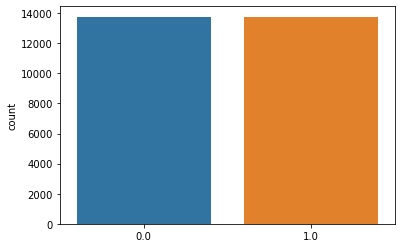

In [36]:
sns.countplot(y_smote)

In [37]:
pd.Series(y_smote).value_counts()

0.0    13765
1.0    13765
dtype: int64

setelah dilakukan motode *SMOTE* maka dapat dilihat data yang kita miliki sekarang sudah imbang dapat dapat digunakan

## MODELS

### Test Train Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

### Mencoba Decision Tree Classifier

In [39]:
dtc = DecisionTreeClassifier()

In [40]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [41]:
print('Akurasi score yang didapat dari menggunakan Decision Tree Classifier adalah :', accuracy_score
     (y_test, dtc.predict(X_test)))

Akurasi score yang didapat dari menggunakan Decision Tree Classifier adalah : 0.8172902288412641


### Mencoba Random Forest Classifier

In [42]:
rfc = RandomForestClassifier()

In [43]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
print('Akurasi score yang didapat dari menggunakan Decision Tree Classifier adalah :', accuracy_score
     (y_test, rfc.predict(X_test)))

Akurasi score yang didapat dari menggunakan Decision Tree Classifier adalah : 0.8399927351979658


### Mencoba XGB Classifier


In [45]:
xgbc = XGBClassifier()

In [46]:
xgbc.fit(X_train, y_train)

[03:49:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
print('Akurasi score yang didapat dari menggunakan Decision Tree Classifier adalah :', accuracy_score
     (y_test, xgbc.predict(X_test)))

Akurasi score yang didapat dari menggunakan Decision Tree Classifier adalah : 0.853614239011987


### Mencoba Gradient Boosting Classifier

In [48]:
gbc = GradientBoostingClassifier()

In [49]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [50]:
print('Akurasi score yang didapat dari menggunakan Decision Tree Classifier adalah :', accuracy_score
     (y_test, gbc.predict(X_test)))

Akurasi score yang didapat dari menggunakan Decision Tree Classifier adalah : 0.8392662549945514


## VALIDATION


In [51]:
skfold = StratifiedKFold(n_splits = 5, random_state=24, shuffle=True) 

dtc_cv = cross_val_score(dtc, X_train, y_train, cv = skfold, scoring='recall')
rfc_cv = cross_val_score(rfc, X_train, y_train, cv = skfold, scoring='recall')
xgbc_cv = cross_val_score(xgbc, X_train, y_train, cv = skfold, scoring='recall')
gbc_cv = cross_val_score(gbc, X_train, y_train, cv = skfold, scoring='recall')

[03:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:49:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:49:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [52]:
# Mencari nilai cross val tiap model

print('CV Decision Tree', dtc_cv) 
print('CV Random Forest', rfc_cv) 
print('CV XG Boost', xgbc_cv) 
print('CV Gradient Boosting', gbc_cv)

CV Decision Tree [0.81748188 0.8111413  0.80797101 0.8120471  0.78160399]
CV Random Forest [0.8428442  0.84012681 0.83831522 0.84646739 0.82147712]
CV XG Boost [0.86096014 0.8428442  0.85824275 0.85960145 0.83869506]
CV Gradient Boosting [0.85914855 0.8423913  0.85371377 0.85688406 0.83778885]


In [53]:
# Mencari nilai rata2 cross val tiap model

print('Mean CV Decision Tree', dtc_cv.mean())
print('Mean CV Random Forest', rfc_cv.mean())
print('Mean CV XG Boosting', xgbc_cv.mean())
print('Mean CV Gradient Boosting', gbc_cv.mean())

Mean CV Decision Tree 0.8060490583321842
Mean CV Random Forest 0.8378461482896974
Mean CV XG Boosting 0.8520687223787291
Mean CV Gradient Boosting 0.8499853069613812


In [54]:
# Melakukan prediksi dengan XGBoost (model yg dipilih dari hasil model performance diatas)

y_pred = xgbc.predict(X_test)

In [55]:
# Mencari nilai model performance

print('recall', recall_score(y_test, y_pred)) 
print('precision', precision_score(y_test, y_pred))
print('f1', f1_score(y_test, y_pred))

recall 0.8650036683785767
precision 0.8433476394849786
f1 0.8540383918869975


## Dari semua model yang telah dicoba hasil yang palung bagus didapatkan oleh XGBClassifier dengan skor 85.2% skor akurasi

## Hyper Parameter Tuning

In [56]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

grid_search = GridSearchCV(
    xgbc, # model
    param_grid = params, # pilihan hyperaparameter
    cv = skfold,
    scoring='recall',
    n_jobs=-1,
    verbose = 1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[03:57:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...
                                     n_estimators=100, n_jobs=8,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_metho

In [57]:
# Menampilkan best score dan best parameter

print('best score', grid_search.best_score_)
print('best params', grid_search.best_params_)

best score 0.8562356763394469
best params {'colsample_bytree': 0.8, 'gamma': 5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}


In [58]:
xgbc_tune = grid_search.best_estimator_.fit(X_train, y_train)
y_pred = xgbc_tune.predict(X_test)
print(classification_report(y_test, y_pred))

[03:57:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85      2780
         1.0       0.84      0.87      0.85      2726

    accuracy                           0.85      5506
   macro avg       0.85      0.85      0.85      5506
weighted avg       0.85      0.85      0.85      5506



### Confusion Matrix

In [59]:
confusion_matrix(y_test, y_pred)

array([[2333,  447],
       [ 364, 2362]], dtype=int64)

In [60]:
#Function untuk mengubah hasil cm ke df

def make_confusion_matrix(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    conf_df = pd.DataFrame(
        {'p_0': [tn, fn, tn+fn], 'p_1': [fp, tp, fp+tp]}, index = ['a_0', 'a_1', 'total_prediction']
    )
    conf_df['total_actual'] = conf_df['p_0'] + conf_df['p_1']
    return conf_df

In [61]:
make_confusion_matrix(confusion_matrix(y_test, y_pred))

,p_0,p_1,total_actual
a_0,2333,447,2780
a_1,364,2362,2726
total_prediction,2697,2809,5506


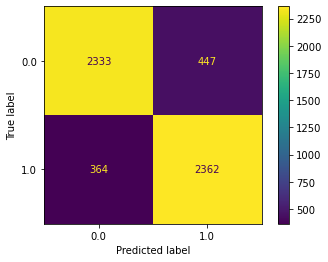

In [62]:
# Menjadikan hasil confusion matrix menjadi plot

plot_confusion_matrix(xgbc_tune, X_test, y_test)
plt.show()

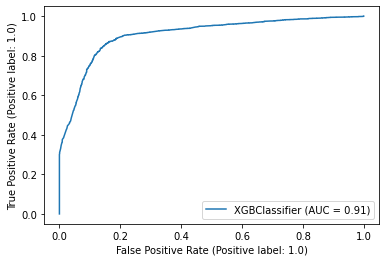

In [63]:
plot_roc_curve(xgbc_tune, X_test, y_test)

In [64]:
# Mendapatkan ROC Curve dengan AUC Score

# a. Membuat proba
proba = xgbc_tune.predict_proba(X_test)
proba_1 = proba[:,1]
fpr, tpr, thr = roc_curve(y_test, proba_1)
auc_score = auc(fpr, tpr)

# b. dijadikan dataframe
thr_df = pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'THR': thr})
thr_df.head()

,TPR,FPR,THR
0,0.000000,0.0,1.999999
1,0.000367,0.0,0.999999
2,0.002935,0.0,0.999994
3,0.004035,0.0,0.999993
4,0.017241,0.0,0.999910


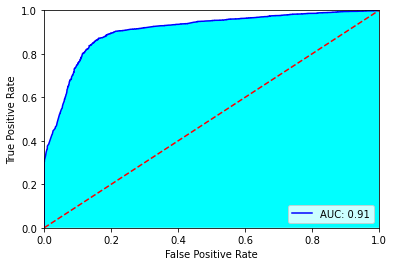

In [65]:
# c. Divisualisasikan dengan menampilkan auc score 

plt.plot(fpr, tpr, 'blue', label= f'AUC: {round(auc_score, 2)}')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.fill_between(fpr, tpr, 0, facecolor='cyan', alpha=1)
plt.legend()
plt.show()

__NOTES:__
<br> AUC adalah area yg dibawah curve dengan nilai sebesar 0.91(sudah cukup bagus).
<br> Semakin mendekati 1 nilai AUC, semakin bagus.
<br> Diharapkan true positive setinggi mungkin (recall) dan false positive serendah mungkin. 
<br> Kemungkinan area threshold berada di sekitar (fpr 0,4 ; tpr 0,8) 

In [66]:
# Mencari data yg berada di threshold

thr_df[(thr_df['TPR']>=0.8) & (thr_df['FPR'] <0.4)]

,TPR,FPR,THR
471,0.800073,0.114388,0.650754
472,0.800073,0.114748,0.649948
473,0.800807,0.114748,0.649573
474,0.800807,0.115108,0.648988
475,0.801541,0.115468,0.648971
...,...,...,...
845,0.934336,0.391007,0.188584
846,0.934336,0.392086,0.188316
847,0.934703,0.392086,0.188209
848,0.935437,0.393525,0.188038


In [67]:
# Membandingkan hasil dengan menggeser threshold dengan hasil default

#HASIL GESER
#a. Menggeser threshold menjadi 0.186804 (baris paling bawah, kolom paling kanan) == tergantung bussiness casenya
y_pred_021 = [1 if prob1 > 0.186804 else 0 for prob1 in xgbc_tune.predict_proba(X_test)[:,1]]

#b. membuat cm geser threshold
make_confusion_matrix(confusion_matrix(y_test, y_pred_021))

,p_0,p_1,total_actual
a_0,1682,1098,2780
a_1,176,2550,2726
total_prediction,1858,3648,5506


In [68]:
# Mengecek nilai recall default

recall_score(y_test, y_pred)

0.8664710198092443

In [69]:
# Mengecek nilai recall hasil geser threshold

recall_score(y_test, y_pred_021)

0.9354365370506236

Nilai tn berkurang dari 2333 -> 1682

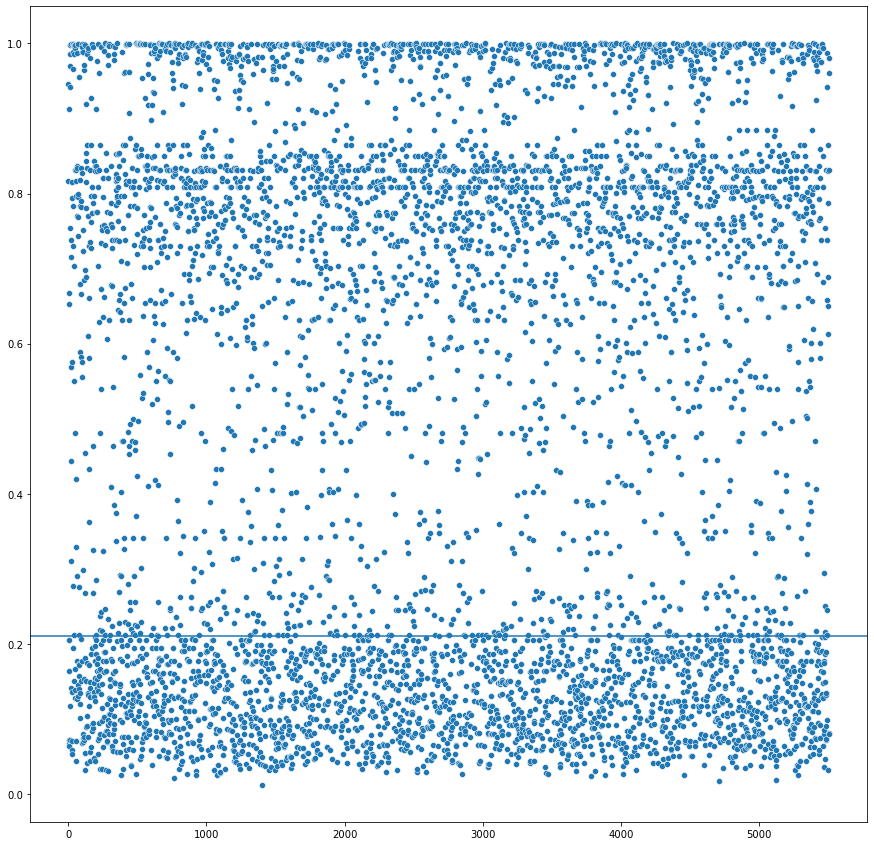

In [70]:
# Membuat plot threshold dipindah
plt.figure(figsize=(15,15))
sns.scatterplot(x=range(len(proba_1)), y=proba_1)
plt.axhline(0.21)

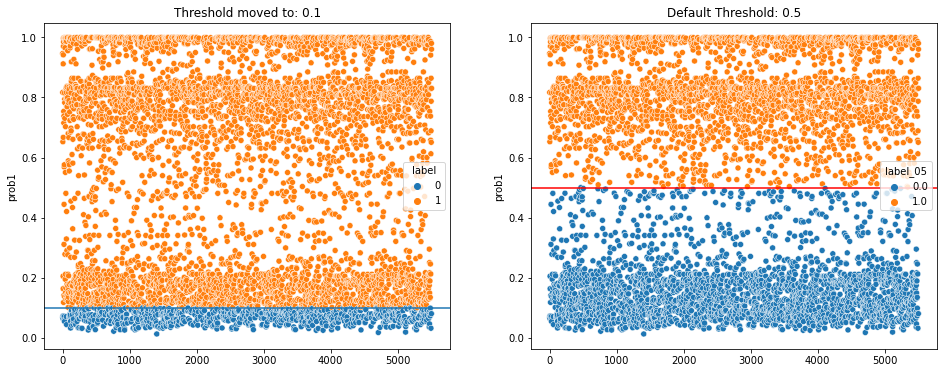

In [134]:
thr_move_to = 0.1
y_pred_thr = np.where(xgbc_tune.predict_proba(X_test)[:,1] > thr_move_to, 1, 0)
# print(classification_report(y_test, y_pred_thr))

thr_test_df = pd.DataFrame(dict(zip(['label', 'prob1', 'label_05'], [y_pred_thr, xgbc_tune.predict_proba(X_test)[:,1], xgbc_tune.predict(X_test)])))
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title(f'Threshold moved to: {thr_move_to}')
sns.scatterplot(x=thr_test_df.index, y=thr_test_df['prob1'], hue=thr_test_df['label'])
plt.axhline(thr_move_to)

plt.subplot(122)
plt.title('Default Threshold: 0.5')
sns.scatterplot(x=thr_test_df.index, y=thr_test_df['prob1'], hue=thr_test_df['label_05'])
plt.axhline(0.5, color='red')

plt.show()

In [71]:
print('ratio pegawai yang tidak akan mencari pekerjaan baru:', 1098/3648*100)
print('ratio pegawai akan mencari pekerjaan baru:', 2550/3648*100)

ratio pegawai yang tidak akan mencari pekerjaan baru: 30.098684210526315
ratio pegawai akan mencari pekerjaan baru: 69.90131578947368


## DEPLOYMENT

> ### __PICKLE__

In [83]:
import pickle
import joblib
# Menyimpan Model
filename = 'xgbc_tune.sav'
pickle.dump(xgbc_tune, open(filename, 'wb'))

In [84]:
# Memanggil model yang sudah kita buat

filename = 'xgbc_tune.sav'
loaded_model = pickle.load((open(filename, 'rb')))
loaded_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [100]:
# mengambil 8 kolom dari test data

testing = aug_test [["city" , "city_development_index","gender",
                     "relevent_experience","enrolled_university","education_level","company_size",
                     "company_type"]]

In [101]:
testing.head(5)

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,company_size,company_type
0,41,0.827,1.0,1,1.0,0.0,0.000000,0.692977
1,103,0.920,2.0,1,0.0,0.0,3.184472,0.000000
2,21,0.624,1.0,0,0.0,2.0,3.184472,0.000000
3,13,0.827,1.0,1,0.0,1.0,1.000000,0.000000
4,103,0.920,1.0,1,0.0,0.0,4.000000,0.000000


In [120]:
pred = loaded_model.predict(testing.values)

In [121]:
# predict = xgbc_tune.predict(testing.values)

In [122]:
sub = pd.DataFrame()

In [123]:
sub['enrollee_id'] = aug_test['enrollee_id']
sub['target'] = pred

In [124]:
sub.head()

,enrollee_id,target
0,32403,0.0
1,9858,1.0
2,31806,1.0
3,27385,0.0
4,27724,0.0


In [125]:
sub.target.value_counts()

1.0    1051
0.0     991
Name: target, dtype: int64

dari hasil diatas denggan menggunakan data set aug test untuk memprediksi hasil, didapatkan sebanyak *1051* orang **Akan Mencari Pekerjaan Baru** dan sebanyak *991* orang **Tidak Akan Mencari Pekerjaan Baru**


In [130]:
#6.membuat deploy

hr = aug_train[['target', 'enrollee_id']]

#data splitting manual(gak perlu di final project, kaggle comp ) 
wine_train = hr[:400]
wine_test = hr[400:]

In [143]:
#Semisal ada data baru, kita bikin inputnya 

#front-end
enroll_id = float(input('Berapa enroll IDnya?: '))
target = float(input('Berapa Target Scorenya?: '))

#back-end
df = pd.DataFrame([[enroll_id, target]], columns = X_train.columns, index = [0])
class_label = loaded_model.predict(df)[0]
proba = loaded_model.predict_proba(df)

if class_label == 0:
    print('Akan Mencari Pekerjaan Baru')
else:
    print('Tidak Akan Mencari Pekerjaan Baru')
    
print(proba)

Berapa enroll IDnya?:  8949
Berapa Target Scorenya?:  1


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

ModuleNotFoundError: No module named 'db_connection'